In [1]:
import importlib
import logging

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.7.3.dev76+gb54020f.d20200406
numpy is version 1.18.1


# Ptychography Reconstruction

This notebook demonstrates a simulated ptychographic reconstruction using tike.

## Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

In [3]:
amplitude = plt.imread("../../../tests/data/Cryptomeria_japonica-0128.png")
phase = plt.imread("../../../tests/data/Bombus_terrestris-0128.png") * np.pi
np.min(phase), np.max(phase)

(0.036959916, 3.1292727)

(-0.9999241+0.012319642j) (0.99514693+0.09840028j)


(1, 128, 128)

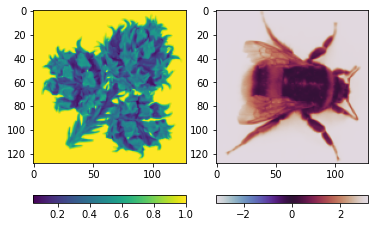

In [4]:
ntheta = 1  # number angular views
original = np.tile(amplitude * np.exp(1j * phase), (ntheta, 1, 1)).astype('complex64')
tike.view.plot_phase(original[0])
original.shape

### Define the probe

Note that the shape of the probe includes many dimensions. These dimensions are for providing unique probes in various situations such as for each projection, for each frame, for each fly scan position, for each incoherent mode.

(-4.371139e-07+10j) (3.5705957+4.027652j)


c:\users\dchin\documents\tike\src\tike\view.py:95: UserWarning: This phase plot will be incorrect because the phase of a zero-amplitude complex number is undefined. Adding a small constant to the amplitude may help.
  "This phase plot will be incorrect because "


(1, 1, 1, 1, 15, 15)

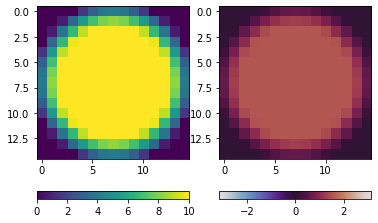

In [5]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * np.pi / 2) * 10
probe = np.tile(probe, (ntheta, 1, 1)).astype('complex64')[:, np.newaxis, np.newaxis, np.newaxis]
tike.view.plot_phase(probe[0, 0, 0, 0])
probe.shape

### Define the trajectory

Each projection may have a different trajectory, but the number of scan positions must be the same. The probe positions that overlap the edge of psi are skipped.

In [6]:
v, h = np.meshgrid(
    np.linspace(0, amplitude.shape[0]-pw-1, 21, endpoint=True),
    np.linspace(0, amplitude.shape[0]-pw-1, 21, endpoint=True),
    indexing='ij'
)

In [55]:
import tike.scan
v, h = tike.scan.hexagonal(
    t=np.arange(0, 21*21),
    D=(amplitude.shape[0]-pw-1) / 21,
    f=1,
    row=21,
)

In [56]:
scan = np.tile(np.stack((np.ravel(v), np.ravel(h)), axis=1), (ntheta, 1, 1)).astype('float32')
scan.shape
assert np.min(scan) >= 0
assert np.max(scan) <= amplitude.shape[0]-pw-1, (np.max(scan), amplitude.shape[0]-pw-1)

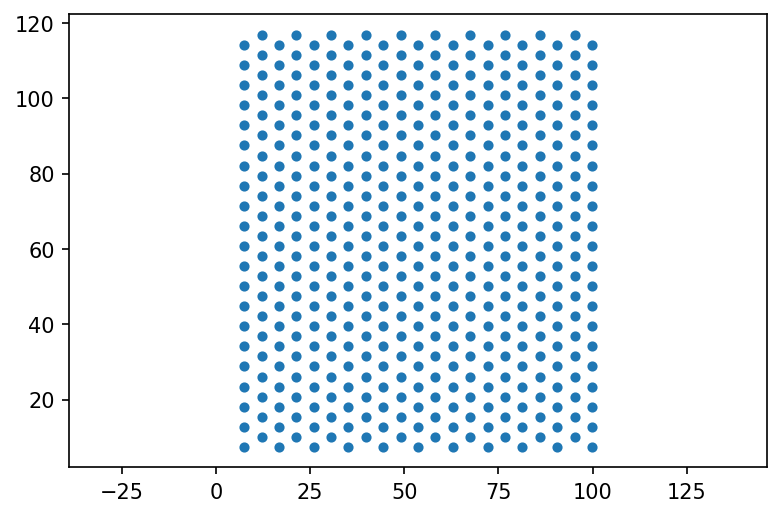

In [57]:
plt.figure(dpi=150)
plt.scatter(scan[0, :, 0] + pw/2, scan[0, :, 1] + pw/2, s=15)
plt.axis('equal')
plt.show()

## Simulate data acquisition

In [10]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=pw*2,
                            probe=probe, scan=scan,
                            psi=original)
np.random.seed(0)
data = np.random.poisson(data)
data.shape

(1, 270, 30, 30)

C:\Users\dchin\Miniconda3\envs\tike\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


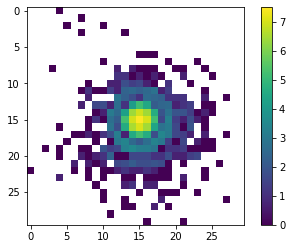

(0, 2198)

In [11]:
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

## Reconstruct

Now we need to try and reconstruct psi.

In [12]:
# Provide initial guesses for parameters that are updated

algorithm, save_iter = 'divided', 10

result = {
    'psi': (np.random.rand(*original.shape) + 1j * np.random.rand(*original.shape)).astype('complex64'),
    'probe': (np.random.rand(*probe.shape) + 1j * np.random.rand(*probe.shape)).astype('complex64'),
    'scan': scan,
    'λ': 0,  # parameter for ADMM
    'μ': 0,  # parameter for ADMM
}

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.80604e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.96033e+05
INFO:tike.ptycho.solvers.divided:     probe cost is +1.29948e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.23473e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.09110e+05
INFO:tike.ptycho.solvers.divided:     probe cost is +6.58370e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.20446e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.51267e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +5.03816e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.65385e-27
INFO:tike.ptycho.solvers.divided:    object cost is +4.62231e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +4.15496e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.55370e-27
INFO:tike.ptycho.solvers.divided:    object cost is +3.81561e+04
INFO:tike.pty

(-13.861384683551773+9.530293892138223j) (19.706557174889046+7.474661957390134j)
(-0.049410934896327516-0.10016188927308319j) (1.2610781737725707+1.322448172447431j)


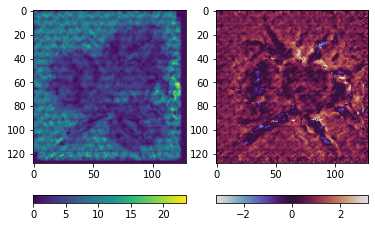

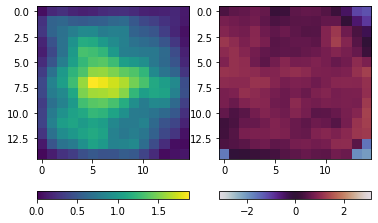

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.10102e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.64476e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.62830e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.78594e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.56486e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.55105e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.82626e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.49626e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.48442e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.30290e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.43273e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.42227e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.63376e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.37437e+04
INFO:tike.pty

(-14.205823036262796+4.288923551755316j) (18.69587618289526+4.862044663790624j)
(-0.03862225809450043-0.02040555127653689j) (1.2506357220774025+1.1191809712285703j)


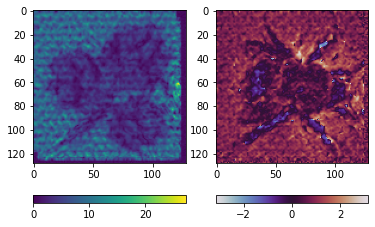

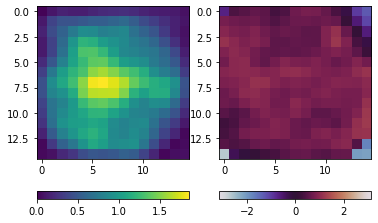

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.81422e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.09553e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.09081e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.28092e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.05878e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.05440e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.15457e-27
INFO:tike.ptycho.solvers.divided:    object cost is +2.01958e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +2.01555e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.33815e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.98635e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.98253e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.80673e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.94980e+04
INFO:tike.pty

(-16.370456758434603+1.234439337617256j) (19.88703225630699+5.748651766177743j)
(-0.041814688195846855-0.009894204951715847j) (1.2421594512057488+1.1666991885015134j)


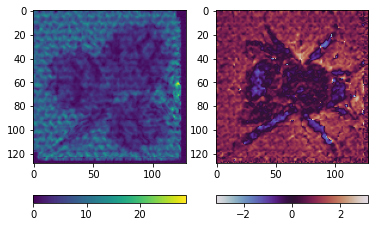

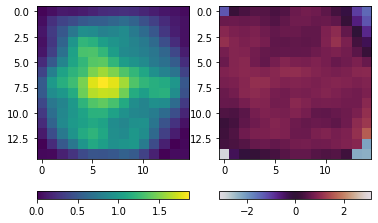

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.85610e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.78244e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.77948e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.50375e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.75337e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.75054e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.11425e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.72890e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.72616e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.65889e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.70357e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.70069e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.37694e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.68519e+04
INFO:tike.pty

(-15.89864427060513+14.909491513249339j) (20.16094965276636+6.240675605480928j)
(-0.044384907540758564-0.007935076125523143j) (1.2243978516687402+1.2012389357097073j)


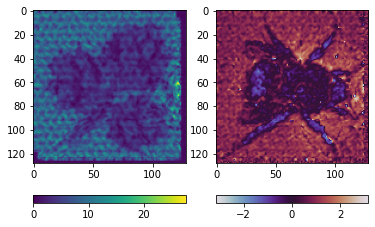

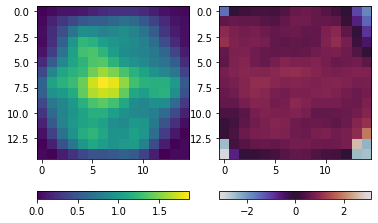

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.13927e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.55351e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.55157e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.96099e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.53323e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.53126e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.52404e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.51456e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.51261e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.42244e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.49708e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.49519e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.22932e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.48023e+04
INFO:tike.pty

(-16.255459663284146+3.8021945116024654j) (19.681324175460944+7.234416812001537j)
(-0.04572753311161156-0.0052868580856125415j) (1.2129482929425657+1.2289162705371222j)


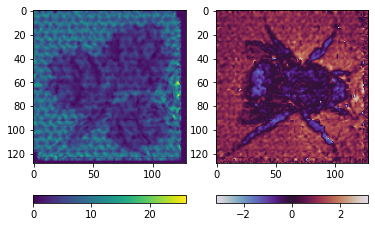

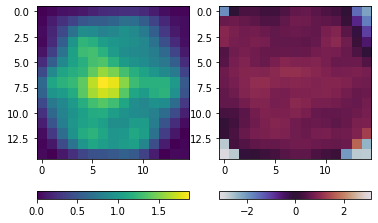

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.26918e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.38547e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.38375e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.35736e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.36893e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.36719e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.16238e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.35352e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.35177e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.80253e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.33942e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.33769e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.63242e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.32495e+04
INFO:tike.pty

(-18.036169557659086+1.1122841583924912j) (18.928068272828806+3.923434805962587j)
(-0.0467341107879169-0.003739748220286391j) (1.1884899535195164+1.2466757169214284j)


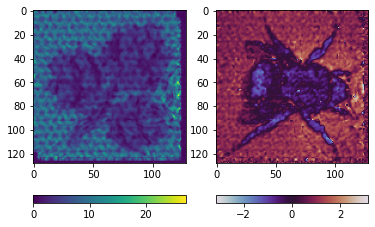

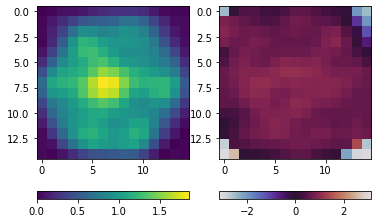

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.26226e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.24701e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.24513e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.64975e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.23618e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.23433e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.16309e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.22501e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.22323e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.67094e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.21380e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.21210e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.94795e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.20273e+04
INFO:tike.pty

(-17.448077366176193-0.8073013631009909j) (17.866784994779387+7.62374673833845j)
(-0.04846716474233962-0.019310882856913816j) (1.1506484226268683+1.262776672068776j)


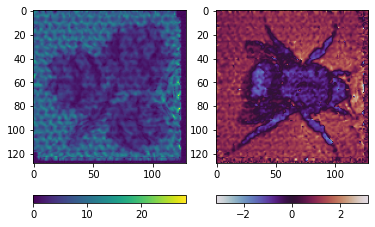

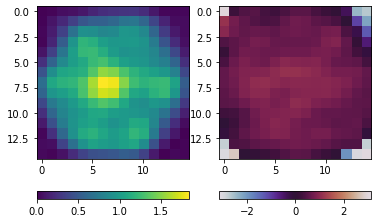

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.57714e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.13681e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.13552e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.51226e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.12602e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.12476e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.52885e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.11501e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.11380e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.74305e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.10404e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.10286e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.79449e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.09325e+04
INFO:tike.pty

(-16.4185062998812-2.6773452484707785j) (16.85351828350789+7.891295517686353j)
(-0.046869951655743904-0.014719693254697904j) (1.103066949939224+1.2698897918319876j)


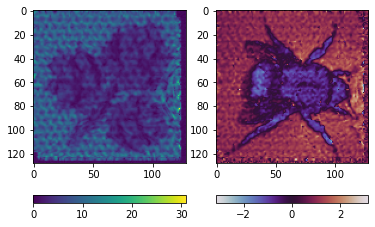

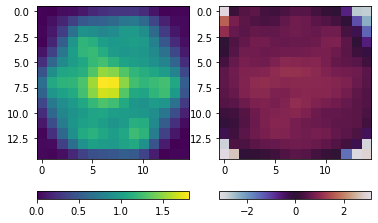

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.52152e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.02955e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.02855e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.31751e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.01610e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.01509e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.33146e-27
INFO:tike.ptycho.solvers.divided:    object cost is +1.00439e+04
INFO:tike.ptycho.solvers.divided:     probe cost is +1.00334e+04
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.43872e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.95658e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +9.94600e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.21060e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.87458e+03
INFO:tike.pty

(-15.989901468487007+14.708748494674603j) (16.70859900440896+7.601226482571998j)
(-0.046799280673395005-0.014425154733810114j) (1.0593062147449435+1.2758831385332672j)


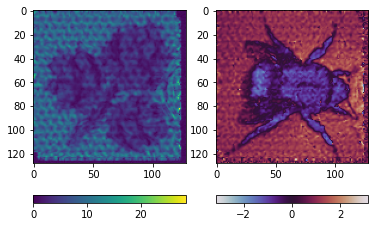

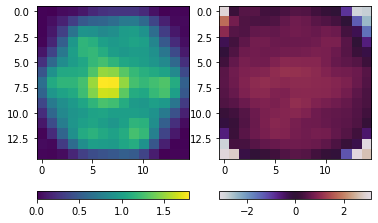

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.50622e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.34175e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +9.33558e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.19465e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.26493e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +9.25919e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.24883e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.19575e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +9.19038e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.41522e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.13329e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +9.12833e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.72904e-27
INFO:tike.ptycho.solvers.divided:    object cost is +9.07456e+03
INFO:tike.pty

(-15.612873833462164+7.755376033479095j) (16.620297711222527+7.777524578701554j)
(-0.042700430132789596-0.013549069639736865j) (1.022910689805869+1.2781330993001476j)


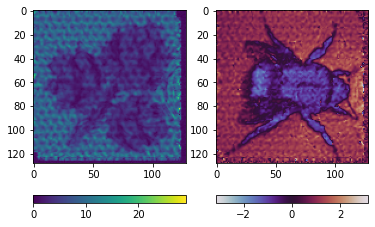

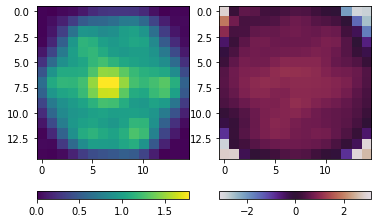

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.15547e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.73583e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.73237e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.84701e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.67671e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.67337e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.12721e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.61708e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.61381e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.43067e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.55540e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.55216e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.78777e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.49012e+03
INFO:tike.pty

(-14.283770240988016+10.669520483470647j) (16.20180522887934+8.509963428588339j)
(-0.038822272979901484-0.01270928054918876j) (0.9946526565197049+1.277500410883665j)


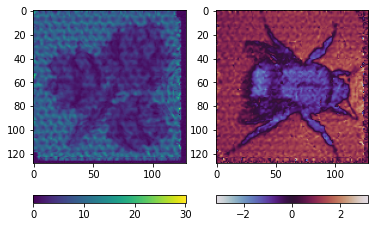

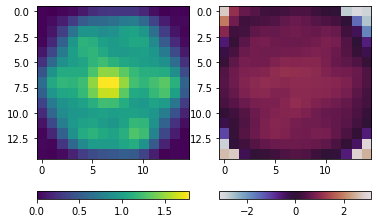

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.46936e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.13923e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.13623e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.06941e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.09708e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.09405e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.40758e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.05666e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.05352e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.72161e-27
INFO:tike.ptycho.solvers.divided:    object cost is +8.01551e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +8.01260e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.68091e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.97312e+03
INFO:tike.pty

(-14.11104873801819+11.290921695493017j) (15.69365897733456+9.249667251504068j)
(-0.038775778045511036-0.010843319040612386j) (0.9717966778131993+1.2785473868224941j)


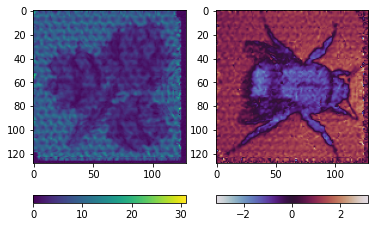

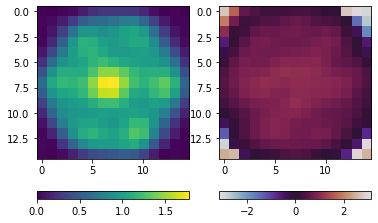

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.25899e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.72856e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.72551e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.15410e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.69113e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.68831e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.22527e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.65531e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.65234e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.78185e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.61942e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.61667e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.31049e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.58770e+03
INFO:tike.pty

(-13.683991086038482+10.876634916178515j) (15.733526692470187+10.270195837422254j)
(-0.039881578996727424-0.008728614862674336j) (0.9519467192967549+1.2806311866873494j)


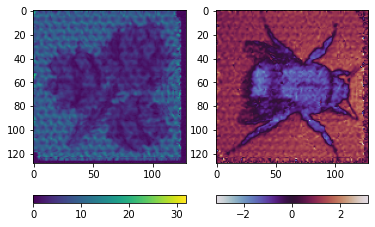

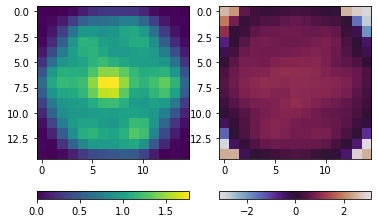

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.95219e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.42531e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.42343e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.68152e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.40103e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.39911e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.20278e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.37830e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.37638e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.22836e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.35753e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.35567e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.43761e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.33703e+03
INFO:tike.pty

(-13.621678000814628+1.8485435466772004j) (16.441519972191465+3.187063832751058j)
(-0.04044643507682779-0.005272600815979756j) (0.9329180285134587+1.2778136069046249j)


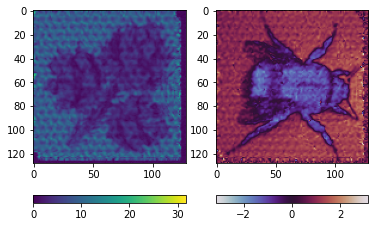

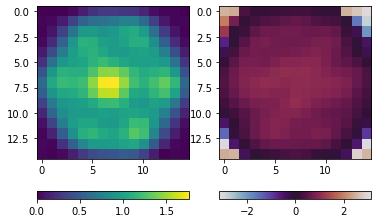

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.87435e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.20516e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.20366e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.73597e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.18412e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.18263e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.67642e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.16515e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.16367e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.21421e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.14538e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.14393e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.94701e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.12622e+03
INFO:tike.pty

(-14.011592673917363+1.4256793986523781j) (17.704990106345573+4.160755920414051j)
(-0.042707794109651066-0.002924357237539844j) (0.9258157644617184+0.7175701446093135j)


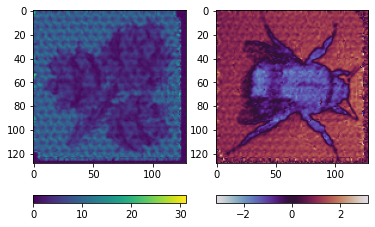

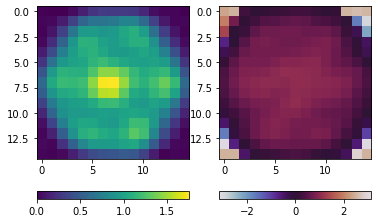

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.14312e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.02450e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.02314e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.97680e-27
INFO:tike.ptycho.solvers.divided:    object cost is +7.00878e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +7.00742e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.49633e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.99460e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.99322e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.55520e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.97914e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.97779e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.06060e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.96445e+03
INFO:tike.pty

(-14.375286235489021+0.8204816371469036j) (19.15413332430707+4.650483634854733j)
(-0.04219067893817143-9.689141559361405e-05j) (0.9310892524078357+0.7141517646008294j)


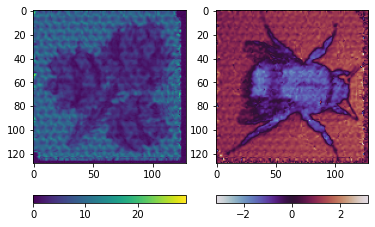

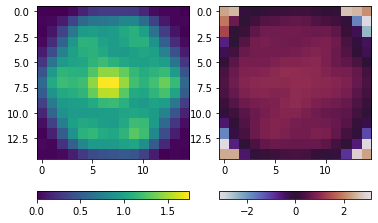

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.30432e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.89084e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.88975e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.03443e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.87871e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.87764e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.45067e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.86616e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.86510e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.36996e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.85420e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.85317e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.44135e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.84313e+03
INFO:tike.pty

(-14.651364368659582+0.54520756613624j) (19.80825424990315+5.199032905063816j)
(-0.04168463535380483+0.0014405377663134183j) (0.936390459434921+0.7167966686335693j)


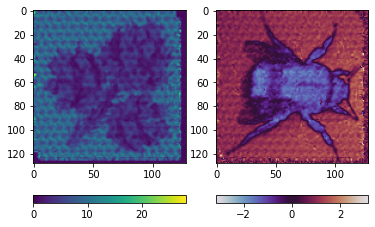

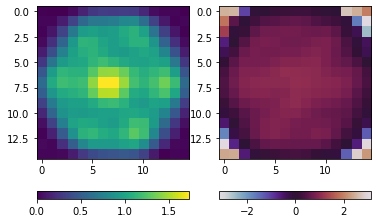

INFO:tike.ptycho.ptycho:divided for 270 - 30 by 30 frames for 10 iterations.
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.74442e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.78727e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.78647e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.29623e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.77963e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.77885e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.77705e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.77154e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.77076e+03
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.34535e-27
INFO:tike.ptycho.solvers.divided:    object cost is +6.76290e+03
INFO:tike.ptycho.solvers.divided:     probe cost is +6.76213e+03


In [ ]:
logging.basicConfig(level=logging.INFO)

for i in range(200 // save_iter):
    result = tike.ptycho.reconstruct(
        data=data,
        **result,
        algorithm=algorithm,
        num_iter=save_iter,
        recover_probe=True,
        cg_iter=4,
    )
    plt.figure()
    tike.view.plot_phase(result['psi'][ntheta // 2], amin=0)
    plt.figure()
    tike.view.plot_phase(result['probe'][0, 0, 0, 0], amin=0)
    plt.show()
#     np.savez(f'{algorithm}.{((i + 1) * save_iter):03d}', **result)

In [ ]:
result.keys()